In [ ]:
%%bash
# pip install tflite-runtime
python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral~=2.0

In [1]:
import os
import sys
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import tensorflow as tf
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from object_detection_ign.wmts.satellite_view import WMTSClient, SatelliteView
from object_detection_ign.detector.inference_helpers import decode_img, draw_bounding_boxes_on_image, filter_predictions, load_inference_model, perform_inference
import picologging as logging
logging.basicConfig()
logger = logging.getLogger()

import ipywidgets as widgets
# from tflite_runtime import interpreter

ModuleNotFoundError: No module named 'object_detection_ign.satellite_view'

In [ ]:
# WMTS_SERVICE_URL = "https://wxs.ign.fr/satellite/geoportail/wmts"
WMTS_SERVICE_URL = "https://wxs.ign.fr/ortho/geoportail/wmts?SERVICE=WMTS"
CORRESPONDANCE_TABLE_URL = "https://developers.arcgis.com/documentation/mapping-apis-and-services/reference/zoom-levels-and-scale/"
DATA_PATH = os.path.join("..","data")
CORRESPONDANCE_TABLE_PATH = os.path.join(DATA_PATH, "correspondance_table.csv")
MODEL_PATH = os.path.join('..', 'models', 'tflite_detector_v2', 'model.tflite')
TEST_IMG_DIR = os.path.join("..", "data", "vedai_corrected", "images")
CLASSES_DICT = {0: "background",
                1: "car",
                2: "truck",
                3: "pickup",
                4: "tractor",
                5: "camping car",
                6: "boat",
                7: "motorcycle",
                8: "bus",
                9: "van",
                10: "other",
                11: "small plane",
                12: "large plane"}
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
client = WMTSClient(
    WMTS_SERVICE_URL, CORRESPONDANCE_TABLE_PATH, CORRESPONDANCE_TABLE_URL
)

# print(client.list_available_zoom_options())
# print(client.list_available_layers())
# satellite_view = client.create_satellite_view_from_address(
#     "Aérodrome de Carpiquet", "HR.ORTHOIMAGERY.ORTHOPHOTOS", 18)
satellite_view = client.create_satellite_view_from_position(
    48.86282492552448, 2.2874596828571394, "HR.ORTHOIMAGERY.ORTHOPHOTOS", 19)

[I 221222 18:37:37 satellite_view:59] Existing correspondance table found, loading it now.


Tile width in meters : 76.43702828517624
X = 310952.81200756493, Y = 6343839.496389251, identifier = 19


100%|██████████| 3/3 [00:08<00:00,  2.77s/it]


[I 221222 18:28:48 inference_helpers:137] System compatible with the Coral TPU.
[I 221222 18:28:48 inference_helpers:151] No Coral TPU has been found. Switching to CPU predictions.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
[I 221222 18:28:56 inference_helpers:168] The selected model uses a (640, 640) size for input images.
[I 221222 18:28:56 satellite_view:42] Resized image from size (768, 768) to size (640, 640).


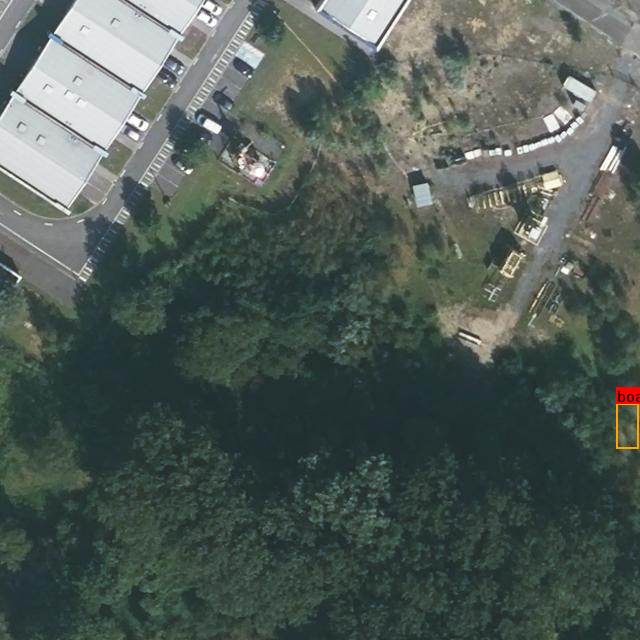

In [4]:
satellite_detector, input_img_width, input_img_height = load_inference_model(MODEL_PATH)
satellite_view.crop_image_center(input_img_width, input_img_height)
scores, labels, bounding_boxes = perform_inference(satellite_detector, satellite_view, CLASSES_DICT, detection_threshold=0.1)

satellite_view.show_image()

In [ ]:
print(output.keys())
# Output 0 : nb detections
# Output 1 : scores
# Output 2 : classes
# Output 3 : bounding boxes
print(output["output_3"])

In [4]:
# chosen_image_widget = widgets.Dropdown(
#     options=os.listdir(TEST_IMG_DIR),
#     # value='2',
#     description='Choose a test picture',
#     # disabled=False,
# )
# display(chosen_image_widget)

# test_img = os.path.join(TEST_IMG_DIR, chosen_image_widget.value)